In [8]:
import pandas as pd
import numpy as np
import nibabel as nib
import brainstat as bs
import hippomaps as hm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import brainspace
import pingouin as pg
import statsmodels.api as sm
import seaborn as sb
import statistics
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from brainspace.mesh.mesh_io import read_surface
from scipy.stats import pearsonr

In [4]:
# --- Inputs: subject-level behavioral and hippunfold-derived volumetric information (left/right)
subfields_L = pd.read_csv("/Users/nimatalaeikamalabadi/Project1/Final_data/GitHubData/comp_antpost_93_L_synthseg_github.csv")
subfields_R = pd.read_csv("/Users/nimatalaeikamalabadi/Project1/Final_data/GitHubData/comp_antpost_93_R_synthseg_github.csv")

# --- Load atlas labels (multihist7)
multihist7_gii = nib.load(
    "/Users/nimatalaeikamalabadi/hippomaps/resources/parc-multihist7/"
    "sub-0_hemi-0_space-0_den-0p5mm_label-hipp_atlas-multihist7_subfields.label.gii"
)
multihist7 = multihist7_gii.darrays[0].data
multihist7_df = pd.DataFrame({"atlas": multihist7})

# --- Subjects to exclude due to segmentation issues or absence of T2w images
exclusion = [
    17, 22, 26, 39, 43, 53, 55, 71, 85, 102, 116, 143, 148, 157, 164, 165, 205,
    4, 5, 6, 7, 9, 10, 11, 13, 18, 19, 20, 24, 25, 27, 31, 34, 35, 38, 41, 42,
    44, 45, 46, 47, 48, 50, 51, 57, 58, 62, 63, 65, 66, 68, 74, 76, 78, 81, 83,
    84, 86, 89, 93, 94, 96, 98, 100, 101, 103, 105, 108, 109, 110, 111, 113, 114,
    117, 119, 120, 121, 122, 124, 128, 129, 131, 133, 137, 139, 140, 142, 147,
    148, 150, 151, 152, 154, 155, 156, 158, 159, 160, 163, 166, 167, 172, 175,
    177, 178, 179, 183, 184, 185, 186, 188, 190, 193, 194, 196, 197, 198, 199,
    200, 206, 207, 208, 209, 215, 217
]

def make_paths(prefix: str, suffix: str, n_subjects: int = 217, exclude=None):
    exclude = set(exclude or [])
    return [
        f"{prefix}{sid}{suffix}"
        for sid in range(1, n_subjects + 1)
        if sid not in exclude
    ]


# 1) GYRIFICATION — LEFT
gyri_L_prefix = (
    "/Users/nimatalaeikamalabadi/computecan/projects/ctb-akhanf/khanlab/trainees/current/"
    "ntalaeik/smoothed_surfaces/smoothed_synthseg_1_gifti/smoothed_sub-"
)
gyri_L_suffix = "_ses-2_hemi-L_space-T2w_den-0p5mm_label-hipp_gyrification_synthseg.shape.gii"
paths_gyri_L = make_paths(gyri_L_prefix, gyri_L_suffix, n_subjects=217, exclude=exclusion)

gyri_L_rows = []
for p in paths_gyri_L:
    g = nib.load(p)
    gyri_L_rows.append(g.darrays[0].data)

gyri_L_dataframe = pd.DataFrame(gyri_L_rows)
gyri_L_with_atlas_T = pd.concat([gyri_L_dataframe, multihist7_df.T]).T

grouped_gyri_L = gyri_L_with_atlas_T.groupby("atlas").mean()
gyri_L_subfield_means = grouped_gyri_L.T
gyri_L_subfield_means.rename(
    columns={1.0: "subfield_1", 2.0: "subfield_2", 3.0: "subfield_3", 4.0: "subfield_4", 5.0: "subfield_5"},
    inplace=True
)

comp_gyri_L_syn = pd.concat([gyri_L_dataframe, subfields_L, gyri_L_subfield_means], axis=1)

# 2) GYRIFICATION — RIGHT
gyri_R_prefix = gyri_L_prefix
gyri_R_suffix = "_ses-2_hemi-R_space-T2w_den-0p5mm_label-hipp_gyrification_synthseg.shape.gii"
paths_gyri_R = make_paths(gyri_R_prefix, gyri_R_suffix, n_subjects=217, exclude=exclusion)

gyri_R_rows = []
for p in paths_gyri_R:
    g = nib.load(p)
    gyri_R_rows.append(g.darrays[0].data)

gyri_R_dataframe = pd.DataFrame(gyri_R_rows)

gyri_R_with_atlas_T = pd.concat([gyri_R_dataframe, multihist7_df.T]).T
grouped_gyri_R = gyri_R_with_atlas_T.groupby("atlas").mean()
gyri_R_subfield_means = grouped_gyri_R.T
gyri_R_subfield_means.rename(
    columns={1.0: "subfield_1", 2.0: "subfield_2", 3.0: "subfield_3", 4.0: "subfield_4", 5.0: "subfield_5"},
    inplace=True
)

comp_gyri_R_syn = pd.concat([gyri_R_dataframe, subfields_R, gyri_R_subfield_means], axis=1)

# 3) THICKNESS — LEFT
thick_L_prefix = gyri_L_prefix
thick_L_suffix = "_ses-2_hemi-L_space-T2w_den-0p5mm_label-hipp_thickness_synthseg.shape.gii"
paths_thick_L = make_paths(thick_L_prefix, thick_L_suffix, n_subjects=217, exclude=exclusion)

thick_L_rows = []
for p in paths_thick_L:
    g = nib.load(p)
    thick_L_rows.append(g.darrays[0].data)

thick_L_dataframe = pd.DataFrame(thick_L_rows)

thick_L_with_atlas_T = pd.concat([thick_L_dataframe, multihist7_df.T]).T
grouped_thick_L = thick_L_with_atlas_T.groupby("atlas").mean()
thick_L_subfield_means = grouped_thick_L.T
thick_L_subfield_means.rename(
    columns={1.0: "subfield_1", 2.0: "subfield_2", 3.0: "subfield_3", 4.0: "subfield_4", 5.0: "subfield_5"},
    inplace=True
)
comp_thick_L_syn = pd.concat([thick_L_dataframe, subfields_L, thick_L_subfield_means], axis=1)

# 4) THICKNESS — RIGHT
thick_R_prefix = gyri_L_prefix
thick_R_suffix = "_ses-2_hemi-R_space-T2w_den-0p5mm_label-hipp_thickness_synthseg.shape.gii"
paths_thick_R = make_paths(thick_R_prefix, thick_R_suffix, n_subjects=217, exclude=exclusion)

thick_R_rows = []
for p in paths_thick_R:
    g = nib.load(p)
    thick_R_rows.append(g.darrays[0].data)

thick_R_dataframe = pd.DataFrame(thick_R_rows)

thick_R_with_atlas_T = pd.concat([thick_R_dataframe, multihist7_df.T]).T
grouped_thick_R = thick_R_with_atlas_T.groupby("atlas").mean()
thick_R_subfield_means = grouped_thick_R.T
thick_R_subfield_means.rename(
    columns={1.0: "subfield_1", 2.0: "subfield_2", 3.0: "subfield_3", 4.0: "subfield_4", 5.0: "subfield_5"},
    inplace=True
)
comp_thick_R_syn = pd.concat([thick_R_dataframe, subfields_R, thick_R_subfield_means], axis=1)


In [6]:
# --- BrainStat SLM ---
# Inputs
BehaviorList = ['InternalTotal', 'Navigation', 'ExternalTotal', 'Future', 'Scene']
gyriList = ['gyri_L_dataframe', 'gyri_R_dataframe']
thickList = ['thick_L_dataframe', 'thick_R_dataframe']
thresholds = [0.001, 0.01]

# Surface (GIFTI to BSPolyData)
canonical_path = "/Users/nimatalaeikamalabadi/hippomaps/resources/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii"
_ = nib.load(canonical_path)
canonical_surf = read_surface(canonical_path, itype='gii', return_data=True, update=True)

# Gyrification
gyri_models = {}
for cluster_thr in thresholds:
    for behavior in BehaviorList:
        for gyri in gyriList:
            FixedBehavior = FixedEffect(comp_gyri_L_syn[behavior])
            Age   = FixedEffect(comp_gyri_L_syn["Age"])
            Sex   = FixedEffect(comp_gyri_L_syn["Sex1M2F"].astype(str))
            Scan  = FixedEffect(comp_gyri_L_syn["Scanner"].astype(str))
            ICV   = FixedEffect(comp_gyri_L_syn["IntracranialVolume"])
            model = FixedBehavior + Age + Sex + Scan + ICV
            contrast = comp_gyri_L_syn[behavior]

            slm = SLM(
                model,
                contrast,
                surf=canonical_surf,
                mask=None,
                correction=["fdr", "rft"],
                cluster_threshold=cluster_thr,
            )
            gyridf = globals()[gyri]
            slm.fit(gyridf)

            key = (cluster_thr, f"{behavior}-{gyri}")
            gyri_models[key] = slm

            if behavior == "InternalTotal" and gyri == "gyri_R_dataframe":
                print(f"\n=== InternalTotal ~ Gyrification Right | cluster_threshold={cluster_thr} ===")
                sig_default = slm.P["clus"][0][slm.P["clus"][0]["P"] < 0.05]
                sig_inverse = slm.P["clus"][1][slm.P["clus"][1]["P"] < 0.05]
                print("\nDefault contrast (significant clusters, FDR/RFT corrected):")
                print(sig_default if not sig_default.empty else "None")
                print("\nInverse contrast (significant clusters, FDR/RFT corrected):")
                print(sig_inverse if not sig_inverse.empty else "None")

# Thickness
thick_models = {}
for cluster_thr in thresholds:
    for behavior in BehaviorList:
        for thick in thickList:
            FixedBehavior = FixedEffect(comp_thick_L_syn[behavior])
            Age   = FixedEffect(comp_thick_L_syn["Age"])
            Sex   = FixedEffect(comp_thick_L_syn["Sex1M2F"].astype(str))
            Scan  = FixedEffect(comp_thick_L_syn["Scanner"].astype(str))
            ICV   = FixedEffect(comp_thick_L_syn["IntracranialVolume"])
            model = FixedBehavior + Age + Sex + Scan + ICV
            contrast = comp_thick_L_syn[behavior]

            slm = SLM(
                model,
                contrast,
                surf=canonical_surf,
                mask=None,
                correction=["fdr", "rft"],
                cluster_threshold=cluster_thr,
            )
            thickdf = globals()[thick]
            slm.fit(thickdf)

            key = (cluster_thr, f"{behavior}-{thick}")
            thick_models[key] = slm


=== InternalTotal ~ Gyrification Right | cluster_threshold=0.001 ===

Default contrast (significant clusters, FDR/RFT corrected):
  clusid nverts              resels                    P
0      1   65.0  0.5584231403684625  0.02548483660338866

Inverse contrast (significant clusters, FDR/RFT corrected):
   clusid  nverts    resels         P
0       1    34.0  0.612749  0.020033

=== InternalTotal ~ Gyrification Right | cluster_threshold=0.01 ===

Default contrast (significant clusters, FDR/RFT corrected):
   clusid  nverts    resels         P
0       1   229.0  1.617452  0.028112

Inverse contrast (significant clusters, FDR/RFT corrected):
   clusid  nverts   resels         P
0       1   168.0  2.53651  0.003333


[]


/Users/nimatalaeikamalabadi/mambaforge/envs/Project1/lib/python3.12/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(
/Users/nimatalaeikamalabadi/mambaforge/envs/Project1/lib/python3.12/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


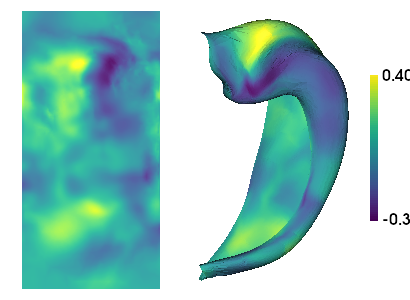

In [13]:
# --- Partial correlation between gyrification (R) and InternalTotal across vertices ---
behaviors = ['InternalTotal', 'ExternalTotal', 'Scene', 'Future', 'Navigation', 'digit_FR_scaled']
covariates = ['Age', 'Sex1M2F', 'Scanner', 'IntracranialVolume']

results_Fut = pd.DataFrame()
vertices = range(0, 7262)
for vertex in vertices:
       result_Fut = pg.partial_corr(data = comp_gyri_R_syn, y = 'InternalTotal', x = vertex, covar=covariates)
       results_Fut = pd.concat([results_Fut, result_Fut], ignore_index=True)
r_values_Fut = np.array(results_Fut['r'], dtype=np.float32)
p_values_Fut = np.array(results_Fut['p-val'], dtype=np.float32)

corrected_results = sm.stats.multipletests(p_values_Fut, alpha=0.05, method='fdr_bh')
significant_results = corrected_results[0]
corrected_pvalues = corrected_results[1]
final_sig = corrected_pvalues[corrected_pvalues < 0.05]
print(final_sig)

gifti_array = r_values_Fut.reshape((7262, 1))
gifti_data_array = nib.gifti.GiftiDataArray(gifti_array)
gifti_image = nib.gifti.GiftiImage(darrays=[gifti_data_array])

hm.plotting.surfplot_canonical_foldunfold(r_values_Fut, labels=['hipp'], color_bar = 'right', share='row', hemis=['R'], embed_nb=True)


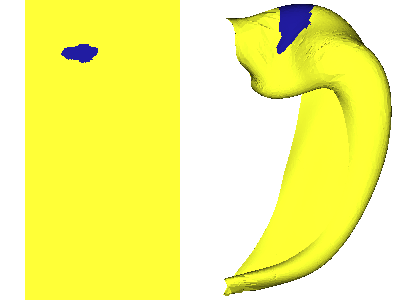

In [ ]:
# --- Visualize clusters for InternalTotal ~ Gyrification (Right) -------------

def get_slm(d, behavior="InternalTotal", gyri_key="gyri_R_dataframe", thr=None):
    if thr is not None and (thr, f"{behavior}-{gyri_key}") in d:
        return d[(thr, f"{behavior}-{gyri_key}")]
    if f"{behavior}-{gyri_key}" in d:
        return d[f"{behavior}-{gyri_key}"]
    # Fallback search
    for k in d:
        if isinstance(k, tuple) and behavior in k[1] and gyri_key in k[1]:
            return d[k]
        if isinstance(k, str) and behavior in k and gyri_key in k:
            return d[k]
    raise KeyError(f"No key for behavior='{behavior}', gyri='{gyri_key}', thr={thr}")

def make_mask(clusid, sig_table):
    n_vertices = clusid.shape[1]
    mask = np.ones(n_vertices, dtype=float)
    if not sig_table.empty:
        for cid in sig_table["clusid"].astype(int):
            verts = (clusid == cid).nonzero()[1]
            mask[verts] = 0.0
    return mask

# Get the fitted model and cluster info
thr = 0.01 
slm = get_slm(gyri_models, behavior="InternalTotal", gyri_key="gyri_R_dataframe", thr=thr)
clusid_list = slm.P["clusid"]        # [default_ids, inverse_ids]
clus_tables = slm.P["clus"]          # [default_table, inverse_table]
sig_tables  = [t[t["P"] < 0.05] for t in clus_tables]

# Build masks
mask_default = make_mask(clusid_list[0], sig_tables[0])
mask_inverse = make_mask(clusid_list[1], sig_tables[1])

# Plotting the positive cluster
hm.plotting.surfplot_canonical_foldunfold(
    mask_default,
    labels=['hipp'],
    hemis=['R'],
    color_bar='right',
    color_range=(0, 0.01),
    cmap="plasma",
    embed_nb=True,
    interactive=False,
)

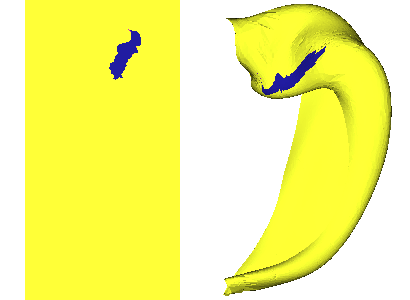

In [ ]:
# Plotting the negative cluster
hm.plotting.surfplot_canonical_foldunfold(
    mask_inverse,
    labels=['hipp'],
    hemis=['R'],
    color_bar='right',
    color_range=(0, 0.01),
    cmap="plasma",
    embed_nb=True,
    interactive=False,
)

In [46]:
# Inspect significant clusters and report the top-r vertex per cluster

slm = get_slm(gyri_models, behavior="InternalTotal", gyri_key="gyri_R_dataframe", thr=thr)

clusid_list = slm.P["clusid"]      
clus_tables = slm.P["clus"]        
contrast_names = ["default", "inverse"]

assert "r_values_Fut" in globals(), "r_values_Fut not found. Run the partial_corr cell first."
n_verts = clusid_list[0].shape[1]
assert len(r_values_Fut) == n_verts, f"r_values_Fut length {len(r_values_Fut)} != n_vertices {n_verts}"

for i, (name, clus_df) in enumerate(zip(contrast_names, clus_tables)):
    sig = clus_df.loc[clus_df["P"] < 0.05]
    print(f"\nSignificant clusters ({name} contrast) at thr={thr}:")
    if sig.empty:
        print("  none")
        continue

    for _, row in sig.iterrows():
        cid = int(row["clusid"])
        n_in_table = int(row["nverts"])
        verts = (clusid_list[i] == cid).nonzero()[1]

        # Vertex with max correlation
        vmax, rmax = max(((v, r_values_Fut[v]) for v in verts), key=lambda x: x[1])

        print(f" nverts(table)={n_in_table} | nverts(mask)={verts.size} | P={row['P']:.4f}")
        print(f"    top vertex: {vmax}  r={rmax:.4f}")


Significant clusters (default contrast) at thr=0.01:
 nverts(table)=229 | nverts(mask)=229 | P=0.0281
    top vertex: 5808  r=0.4048

Significant clusters (inverse contrast) at thr=0.01:
 nverts(table)=168 | nverts(mask)=168 | P=0.0033
    top vertex: 912  r=-0.2412


Pearson r at vertex 5808: 0.3746
95% CI (bootstrap): [0.2010, 0.5291]


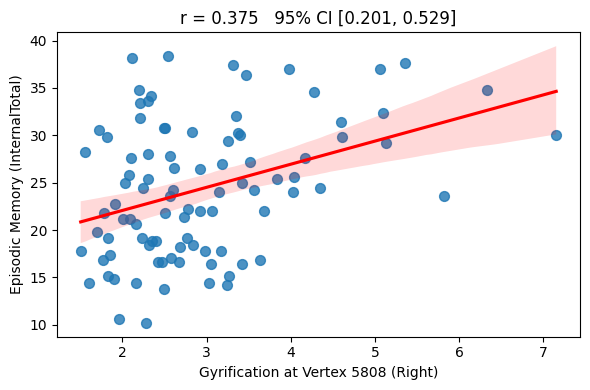

In [ ]:
vertex_id = 5808
cols = comp_gyri_R_syn.columns

if vertex_id in cols:
    vertex_col = vertex_id
elif str(vertex_id) in cols:
    vertex_col = str(vertex_id)
elif f"vertex_{vertex_id}" in cols:
    vertex_col = f"vertex_{vertex_id}"
else:
    matches = [c for c in cols if str(c).endswith(f"_{vertex_id}")]
    if not matches:
        raise KeyError(f"Could not find a column for vertex {vertex_id}. "
                       f"Available example cols: {list(map(str, cols[:10]))} ...")
    vertex_col = matches[0]


data = comp_gyri_R_syn[[vertex_col, 'InternalTotal']].dropna()
x = data[vertex_col].astype(float).values
y = data['InternalTotal'].astype(float).values

r, _ = pearsonr(x, y)

rng = np.random.default_rng(42)
boot_r = []
for _ in range(1000):
    idx = rng.integers(0, len(x), len(x))
    rb, _ = pearsonr(x[idx], y[idx])
    boot_r.append(rb)
ci_lower, ci_upper = np.percentile(boot_r, [2.5, 97.5])

print(f"Pearson r at vertex {vertex_id}: {r:.4f}")
print(f"95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- plot ---
plt.figure(figsize=(6,4))
sb.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ci=95)
plt.xlabel(f'Gyrification at Vertex {vertex_id} (Right)')
plt.ylabel('Episodic Memory (InternalTotal)')
plt.title(f'r = {r:.3f}   95% CI [{ci_lower:.3f}, {ci_upper:.3f}]')
plt.tight_layout()
plt.show()

Using column for vertex 912: 912
Pearson r at vertex 912: -0.2219
95% CI (bootstrap): [-0.3929, -0.0240]


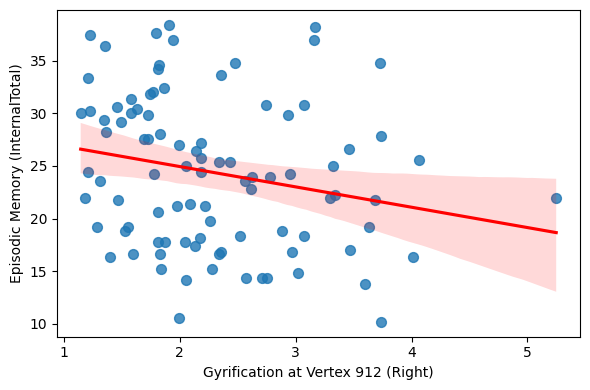

In [ ]:
vertex_id = 912
cols = comp_gyri_R_syn.columns

if vertex_id in cols:
    vertex_col = vertex_id
elif str(vertex_id) in cols:
    vertex_col = str(vertex_id)
elif f"vertex_{vertex_id}" in cols:
    vertex_col = f"vertex_{vertex_id}"
else:
    matches = [c for c in cols if str(c).endswith(f"_{vertex_id}")]
    if not matches:
        raise KeyError(f"Could not find a column for vertex {vertex_id}")
    vertex_col = matches[0]

print(f"Using column for vertex {vertex_id}: {vertex_col}")

data = comp_gyri_R_syn[[vertex_col, 'InternalTotal']].dropna()
x = data[vertex_col].astype(float).values
y = data['InternalTotal'].astype(float).values

r, _ = pearsonr(x, y)
rng = np.random.default_rng(42)
boot_r = []
for _ in range(1000):
    idx = rng.integers(0, len(x), len(x))
    rb, _ = pearsonr(x[idx], y[idx])
    boot_r.append(rb)
ci_lower, ci_upper = np.percentile(boot_r, [2.5, 97.5])

print(f"Pearson r at vertex {vertex_id}: {r:.4f}")
print(f"95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")

comp_gyri_R_syn['_vertex'] = comp_gyri_R_syn[vertex_col]
formula = 'InternalTotal ~ _vertex + Age + C(Sex1M2F) + C(Scanner) + IntracranialVolume'
model = smf.ols(formula=formula, data=comp_gyri_R_syn).fit()

# --- plot ---
plt.figure(figsize=(6, 4))
sb.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={'color': 'red'}, ci=95)
plt.xlabel(f'Gyrification at Vertex {vertex_id} (Right)')
plt.ylabel('Episodic Memory (InternalTotal)')
plt.tight_layout()
plt.show()

Using columns: 5808 -> 5808, 912 -> 912
Pearson r (ratio 5808/912): 0.3713
95% CI (bootstrap): [0.2126, 0.5352]


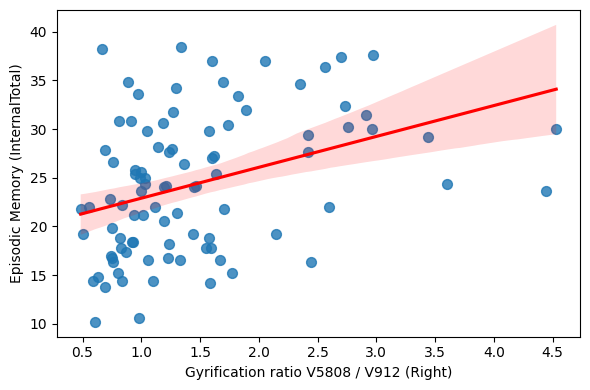

In [ ]:
def get_vertex_col(df, vid: int):
    cols = df.columns
    if vid in cols: return vid
    svid = str(vid)
    if svid in cols: return svid
    vname = f"vertex_{vid}"
    if vname in cols: return vname
    matches = [c for c in cols if str(c).endswith(f"_{vid}")]
    if matches: return matches[0]
    raise KeyError(f"Could not find a column for vertex {vid}. "
                   f"Sample columns: {list(map(str, cols[:10]))} ...")

v1_id, v2_id = 5808, 912
v1_col = get_vertex_col(comp_gyri_R_syn, v1_id)
v2_col = get_vertex_col(comp_gyri_R_syn, v2_id)
print(f"Using columns: {v1_id} -> {v1_col}, {v2_id} -> {v2_col}")

# --- compute the ratio
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = (comp_gyri_R_syn[v1_col].astype(float) /
             comp_gyri_R_syn[v2_col].astype(float)).replace([np.inf, -np.inf], np.nan)

data = (
    pd.DataFrame({"vertex_ratio": ratio, "InternalTotal": comp_gyri_R_syn["InternalTotal"]})
      .dropna()
)

# --- Pearson correlation
x = data["vertex_ratio"].values.astype(float)
y = data["InternalTotal"].values.astype(float)

r, _ = pearsonr(x, y)
rng = np.random.default_rng(42)
boot_r = []
for _ in range(1000):
    idx = rng.integers(0, len(x), len(x))
    rb, _ = pearsonr(x[idx], y[idx])
    boot_r.append(rb)
ci_lower, ci_upper = np.percentile(boot_r, [2.5, 97.5])

print(f"Pearson r (ratio {v1_id}/{v2_id}): {r:.4f}")
print(f"95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- run multiple regression
comp_gyri_R_syn["_vertex_ratio"] = ratio 
formula = "InternalTotal ~ _vertex_ratio + Age + C(Sex1M2F) + C(Scanner) + IntracranialVolume"
model = smf.ols(formula=formula, data=comp_gyri_R_syn).fit()

# --- plot ---
plt.figure(figsize=(6, 4))
sb.regplot(x=x, y=y, scatter_kws={"s": 50}, line_kws={"color": "red"}, ci=95)
plt.xlabel(f"Gyrification ratio V{v1_id} / V{v2_id} (Right)")
plt.ylabel("Episodic Memory (InternalTotal)")
plt.tight_layout()
plt.show()